<a href="https://colab.research.google.com/github/JCardenas05/Teoria_Se-ales/blob/main/Taller_4/Taller_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Binary Signal Detection

Sets representing a finite number of indexed objects/states or relationships (symbols)

$
		{\textrm{Tx: } \{p(a_n)\}: {\bm{a}} }\longrightarrow {\textrm{Cx: }y = {\bm{a}} +\eta :\mathcal{N}_{\eta}(0,\sigma_{\eta}) }\longrightarrow {\textrm{Rx: } \textrm{compare: }\operatorname{M}({\bm{a}},\bm{\hat{a}})\Rightarrow\{p(y|a_n)\}}
		$

In [1]:
import numpy as np
import math

from scipy import signal
from scipy.signal import lti
from scipy.integrate import quad
import scipy.stats
from scipy.fft import fft , fftfreq ,fftshift
import seaborn as sns

import matplotlib.pyplot as plt  # data plotting
from matplotlib import rcParams

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

rcParams['figure.figsize']     = [15,6]
rcParams['lines.markersize']   = 9         # marker size in points
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['figure.dpi']     = 180

from matplotlib import colors
from ipywidgets import interact


Histogram computation

In [2]:
def coloredhist(X, plot):

    """
    Crea un histograma coloreado en función de la frecuencia de los valores.

    Parámetros:
    - X: Datos a graficar.
    - plot: Índice del gráfico.
    """
    Nbins = int(1 + 3.322*np.log2(len(X)))  # Cálculo del número de bins usando la regla de Sturges
    # Creación del histograma
    n, bins, patches = ax[plot].hist(X, bins=Nbins, density=True)
    # Normalización de las frecuencias para determinar colores
    fracs = n / n.max()
    norm = colors.Normalize(fracs.min(), fracs.max())
    # Asignación de colores según la frecuencia relativa
    for thisfrac, thispatch in zip(fracs, patches):
        color = plt.cm.viridis(norm(thisfrac))
        thispatch.set_facecolor(color)
    plt.grid()  # Añadir rejilla al gráfico
    return


In [3]:
# Funciones para calcular la pdf de una distribución normal con media positiva y negativa
def normal_distribution_function_r(x,mean,std):
    value = scipy.stats.norm.pdf(x, mean, std)  # Calcular la pdf con media positiva
    return value

def normal_distribution_function_l(x,mean,std):
    value = scipy.stats.norm.pdf(x, -mean, std)  # Calcular la pdf con media negativa
    return value

In [4]:
def norMaxMin(data):
    """
    Normaliza los datos basándose en el valor mínimo y máximo.

    Parámetros:
    - data: Datos a normalizar.

    Retorna:
    - Datos normalizados.
    """
    min_value = np.min(data)  # Encuentra el valor mínimo en los datos
    max_value = np.max(data)  # Encuentra el valor máximo en los datos
    # Normaliza los datos usando los valores mínimo y máximo
    return (data - min_value) / (max_value - min_value)


In [5]:
import os  # Importa el módulo os para interactuar con el sistema operativo

def clearConsole():
    """Limpia la consola o terminal."""
    command = 'clear'  # Comando por defecto para sistemas Unix/Linux
    # Si el sistema operativo es Windows, usa el comando 'cls'
    if os.name in ('nt', 'dos'):
        command = 'cls'
    os.system(command)  # Ejecuta el comando para limpiar la consola

In [6]:
def generate_data(Nsample,seed=17):
    # Fix the seed to reproduce the results
    rand = np.random.RandomState(seed)
    x = []
    dat = rand.lognormal(0, np.pi/10, Nsample)
    x = np.concatenate((x, dat))
    dat = rand.normal(np.pi, 1, Nsample)
    x = np.concatenate((x, dat))
    return x

#### Tx
message = $\{a_n{\in }\mathbb{R}:n {\in} N\}$ --  {alphabet}

$\{p_i\in\mathbb{R}[0,1]\}$

In [7]:
clearConsole()

# Generación de datos simbólicos
a1 = 1       # Valor del símbolo a1
a0 = -1      # Valor del símbolo a0
Nsamples = 2048  # Muestras de tiempo por símbolo
# Probabilidades de los símbolos
p_0 = 0.25
p_1 = 1 - p_0

Nsymbols = 128  # Número total de símbolos
N = Nsymbols * Nsamples  # Número total de muestras

# Genera una secuencia de símbolos basados en las probabilidades dadas
data = np.random.choice([a0, a1], size=Nsymbols, p=[p_0, p_1])
# Repite cada símbolo según el número de muestras por símbolo
data = np.concatenate([[v]*Nsamples for v in data])
message = data  # Almacena la secuencia completa en la variable 'message'


#### Cx
Channel simulation: Additive White Gaussian Noise: $\eta(t),$ with $\mathbb{E}\{\eta(t)\}=0$

In [8]:
def kde_function(signal_x,eval_points=None,method="Silverman",res=500):
    """
    Aplica el método de KDE gaussiano a la señal proporcionada y ajusta
    automáticamente el ancho de banda mediante una búsqueda en la cuadrícula.

    Parámetros:
    - signal: Señal a la que se aplica KDE.

    Retorna:
    - eval_points: Vector de evaluación.
    - y_sp: Función de densidad estimada en los puntos de evaluación.
    """

    if method == 'Silverman':
        n = len(data)
        sigma = np.std(data)
        optimal_bandwidth = (4 / (3 * n)) ** (1 / 5) * sigma
        print(f'Method:{method}\nOptimal bandwidth: {optimal_bandwidth:.2f}')

    elif method == 'Cross Validation':
        # Define los posibles valores para el ancho de banda
        bandwidths = np.arange(0.05, 2, 0.05)

        # Crea y configura el objeto para la búsqueda en la cuadrícula
        kde = KernelDensity(kernel='gaussian')
        grid = GridSearchCV(kde, {'bandwidth': bandwidths})
        grid.fit(signal_x.reshape(-1, 1))

        # Obtiene el mejor estimador y su ancho de banda óptimo
        kde_optimal = grid.best_estimator_
        optimal_bandwidth = kde_optimal.bandwidth
        print(f'Optimal bandwidth: {optimal_bandwidth:.2f}')

    else:
        print('Error')
        return

    kde = scipy.stats.gaussian_kde(signal_x, bw_method=optimal_bandwidth)

    if eval_points is None:
        eval_points = np.linspace(np.min(signal_x), np.max(signal_x),res)

    y_sp = kde.pdf(eval_points)
    return (eval_points, y_sp)

Method:Silverman
Optimal bandwidth: 0.08


(0.0, 262144.0)

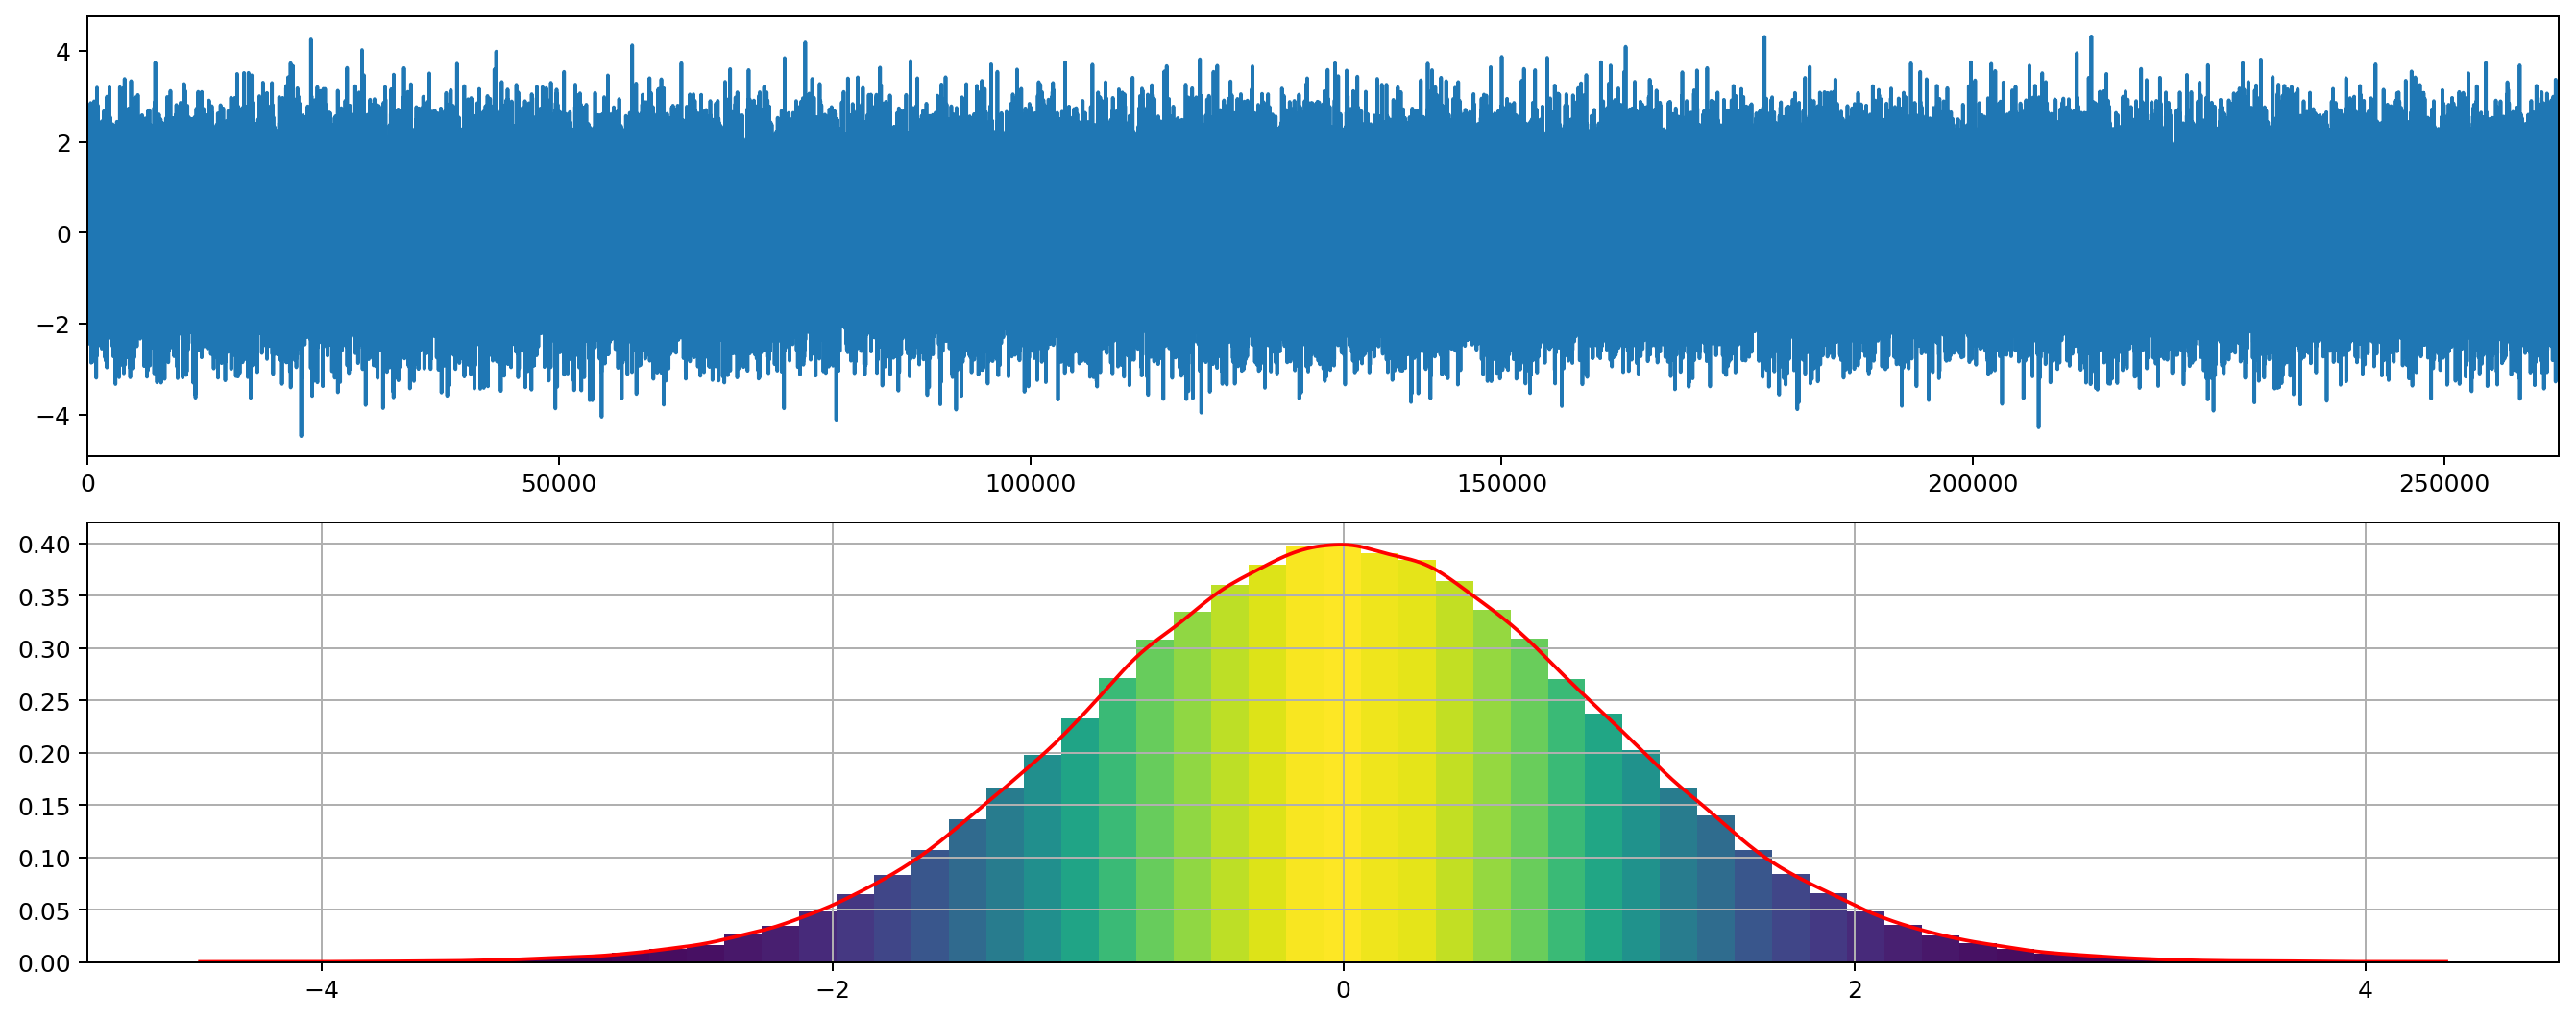

In [9]:
# Definición del vector de tiempo
time = np.linspace(0, N, N)
# Cálculo del número de bins usando la regla de Sturges
Nbins = int(1 + 3.322*np.log2(len(data)))
weight = np.ones_like(message) / N  # Pesos para el histograma

# Creación de gráficos
fig, ax = plt.subplots(2, 1, tight_layout=True)

# Generación de ruido gaussiano de media cero
σ2 = 1  # Varianza del ruido
noise = np.random.normal(0, σ2, N)

# Estimación de la pdf del ruido
x_train  = generate_data(Nsamples)[:, np.newaxis]

pdf_x, pdf_y = kde_function(noise)

# Visualización del ruido y su pdf
ax[0].plot(time, noise)
ax[1].plot(pdf_x, pdf_y, "-r")
coloredhist(noise, plot=1)
ax[0].set_xlim(0, len(message))


In [10]:
#Chi-Square Normality Test
from scipy import stats

def Test_Chi_Square(data):
    print('Chi-Square Test')
    stat_3, p_3 = stats.chisquare(data)
    x_3 = False
    print(f"stat= {round(stat_3,3)}, p= {round(p_3,5)}")
    if p_3 > 0.05:
        x_3 = True
        print("Probably Gaussian")
    else:
        print("Probably not Gaussian")
    return stat_3, p_3, x_3

Test_Chi_Square(message)

Chi-Square Test
stat= 568688.64, p= 0.0
Probably not Gaussian


(568688.6400000005, 0.0, False)

Additive Gaussian Channel
$y(t) = \sum_{\forall k}{{a}_n}\operatorname{rect}_{\delta t}(t-k\delta t) +\eta(t)$

Method:Silverman
Optimal bandwidth: 0.08


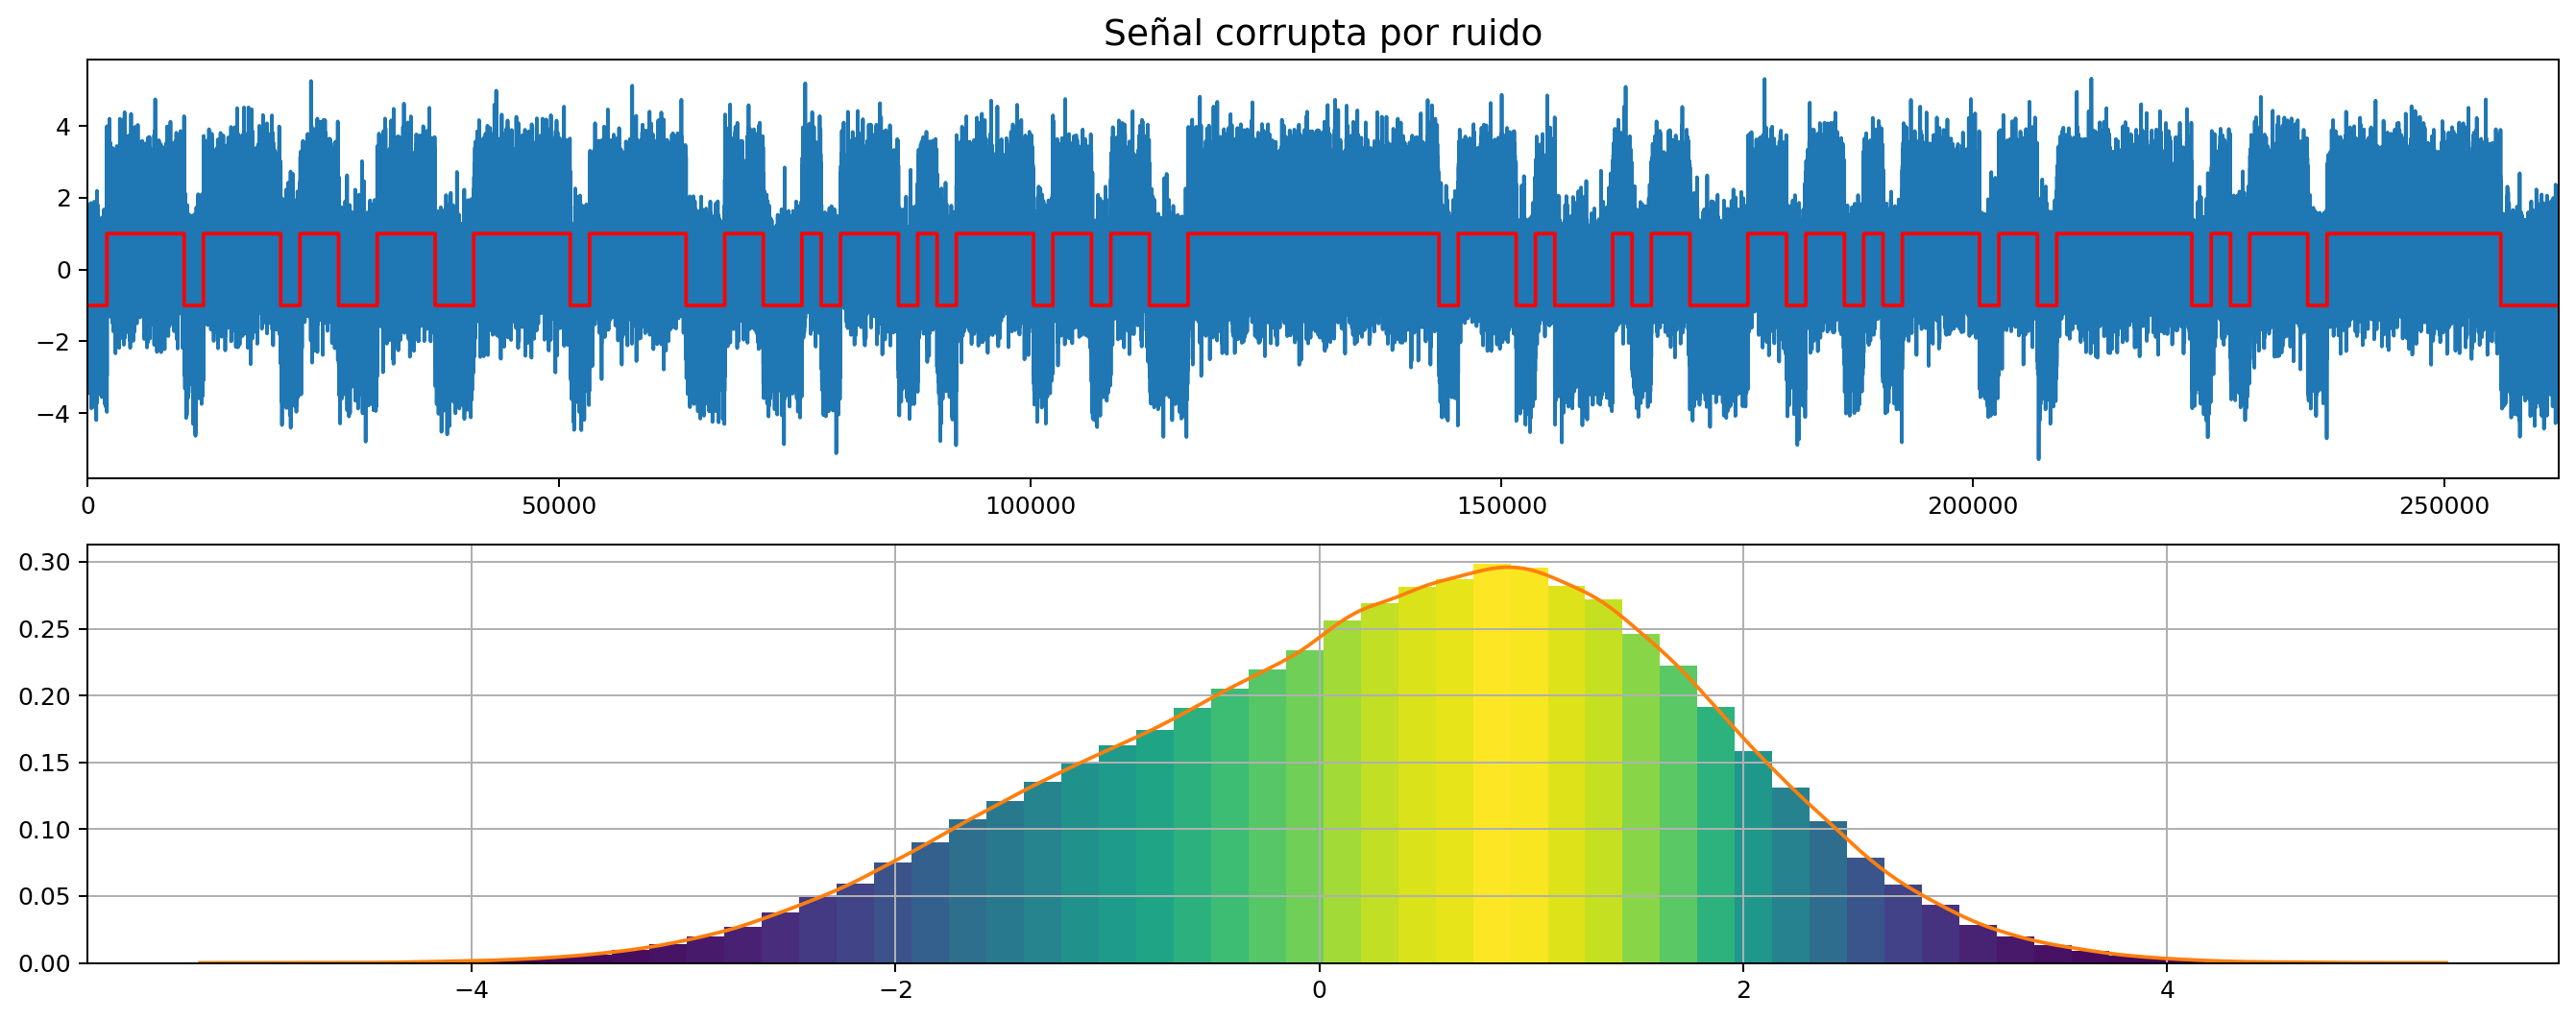

In [11]:
# Generación de la señal corrupta sumando el mensaje y el ruido
y = message + noise
y_pdf_x, y_pdf_y = kde_function(y)
fig, ax = plt.subplots(2, 1, tight_layout=True)
ax[0].step(time, y, '-')
ax[0].set_title('Señal corrupta por ruido')
ax[0].set_xlim(0, N)
ax[0].step(time, message, '-r')
coloredhist(y, plot=1)
ax[1].plot(y_pdf_x, y_pdf_y)
plt.show()

In [12]:
Test_Chi_Square(y)

Chi-Square Test
stat= 1240040.755, p= 0.0
Probably not Gaussian


(1240040.7545076355, 0.0, False)

#### Rx
smoothing by a RC low-band pass filter

In [13]:
# Definición de parámetros para el filtro suavizante
R = 3000
C = .0003
num = [1]
den = [R * C, 1]

# Obtención de la respuesta al impulso y función de transferencia del filtro
lti_system = lti(num, den)
t, h = lti_system.impulse(N)
coeff = fftshift(fft(h))
f = fftshift(fftfreq(coeff.shape[0], t[1] - t[0]))

# Aplicación del filtro a la señal corrupta
_, output0_, _ = lti_system.output(y, time)
output_pdf = kde_function(output0_)


Method:Silverman
Optimal bandwidth: 0.08


/tmp/ipykernel_4420/2465676501.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax[0] = plt.subplot(grid[0, 0])
/home/jony/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jony/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


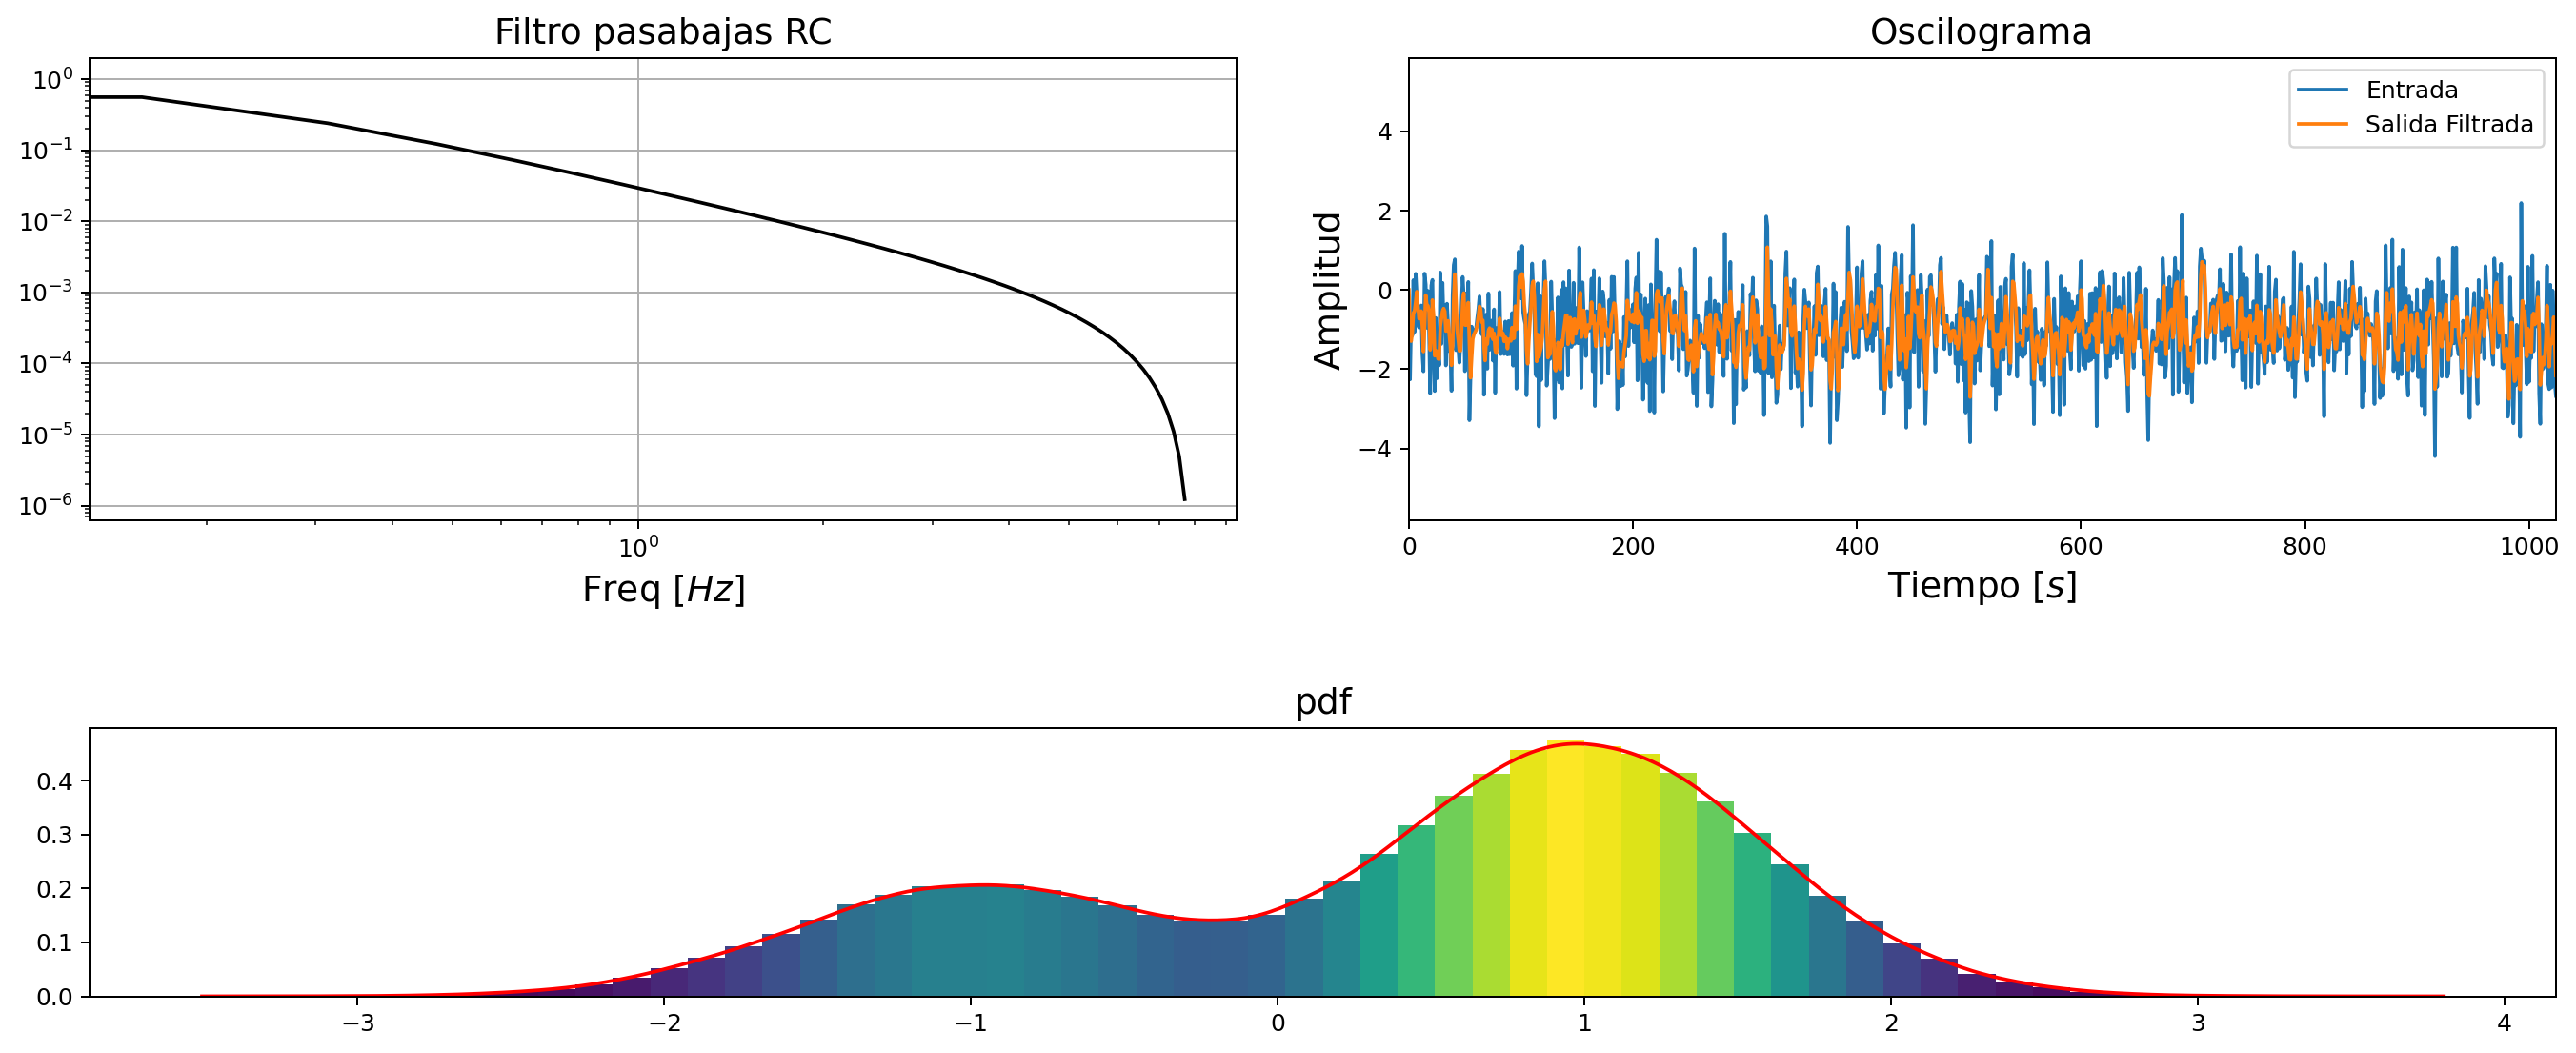

In [14]:
# Creación de gráficos
fig, ax = plt.subplots(3, 1, tight_layout=True)

# Configuración de la disposición de los gráficos
grid = plt.GridSpec(2, 2, wspace=0.15, hspace=0.03)
ax[0] = plt.subplot(grid[0, 0])
ax[0].set_title('Filtro pasabajas RC')
# Visualización de la respuesta en frecuencia del filtro
ax[0].loglog(f, norMaxMin(coeff), 'k')
ax[0].set_xlabel('Freq [$Hz$]')
ax[0].grid()

ax[1] = plt.subplot(grid[0, 1])
# Visualización del oscilograma de las señales de entrada y salida del filtro
ax[1].plot(time, y, label='Entrada')
ax[1].plot(time, output0_, label='Salida Filtrada')
ax[1].set_title('Oscilograma')
ax[1].set_xlim(0, Nsamples/2)
ax[1].grid(True)
ax[1].set_xlabel('Tiempo [$s$]')
ax[1].set_ylabel('Amplitud')

# Visualización de la pdf estimada de la señal filtrada
ax[2].set_title('pdf')
ax[2].plot(output_pdf[0], output_pdf[1],color='r')
coloredhist(output0_, plot=2)
plt.legend()
plt.show()

$\varLambda (y)=  {{p(y|a_1 )}}/{{p(y|a_0 )}} \textrm{   Likelihood ratio}$

In [15]:
def error_umbral(umbral,S0,S1):
    # Filtrar los datos dentro de los límites de integración

    Error = []
    std = np.sqrt(σ2)
    S0_pdf = S1
    S1_pdf = S0

    for u in umbral:

        ainf_0 = a1-6*std
        true_values_0 = (S0_pdf[0] >= ainf_0) & (S0_pdf[0] <= u)

        y0_pdf = S0_pdf[1][true_values_0]
        x0_pdf = S0_pdf[0][true_values_0]

        h_0 = np.diff(x0_pdf)  # Calcula el ancho de cada subintervalo
        int_1 = 0.5 * h_0 * (y0_pdf[:-1] + y0_pdf[1:])  # Calcula el área de cada trapecio
        int_1 = np.sum(int_1)

        ainf_1 = a0+6*std
        true_values_1 = (S1_pdf[0] >= u) & (S1_pdf[0] <= ainf_1)

        y1_pdf = S1_pdf[1][true_values_1]
        x1_pdf = S1_pdf[0][true_values_1]

        h_1 = np.diff(x1_pdf)  # Calcula el ancho de cada subintervalo
        int_2 = 0.5 * h_1 * (y1_pdf[:-1] + y1_pdf[1:])  # Calcula el área de cada trapecio
        int_2 = np.sum(int_2)

        Error.append(p_0 * int_1 + p_1 * int_2)

    return Error[::-1]


Simbol_0 = a0+noise #np.random.normal(a0,np.sqrt(σ2),N)
Simbol_1 = a1+noise#np.random.normal(a1,np.sqrt(σ2),N)

x_min= min(np.min(Simbol_0),np.min(Simbol_1))
x_max= max(np.max(Simbol_0),np.max(Simbol_1))

x=np.linspace(x_min,x_max,500)

S0_pdf = kde_function(Simbol_0,eval_points = x)
S1_pdf = kde_function(Simbol_1, eval_points = x)
umbral=kde_function(output0_)

error = error_umbral(umbral[0],S0_pdf,S1_pdf)


Method:Silverman
Optimal bandwidth: 0.08
Method:Silverman
Optimal bandwidth: 0.08
Method:Silverman
Optimal bandwidth: 0.08


500


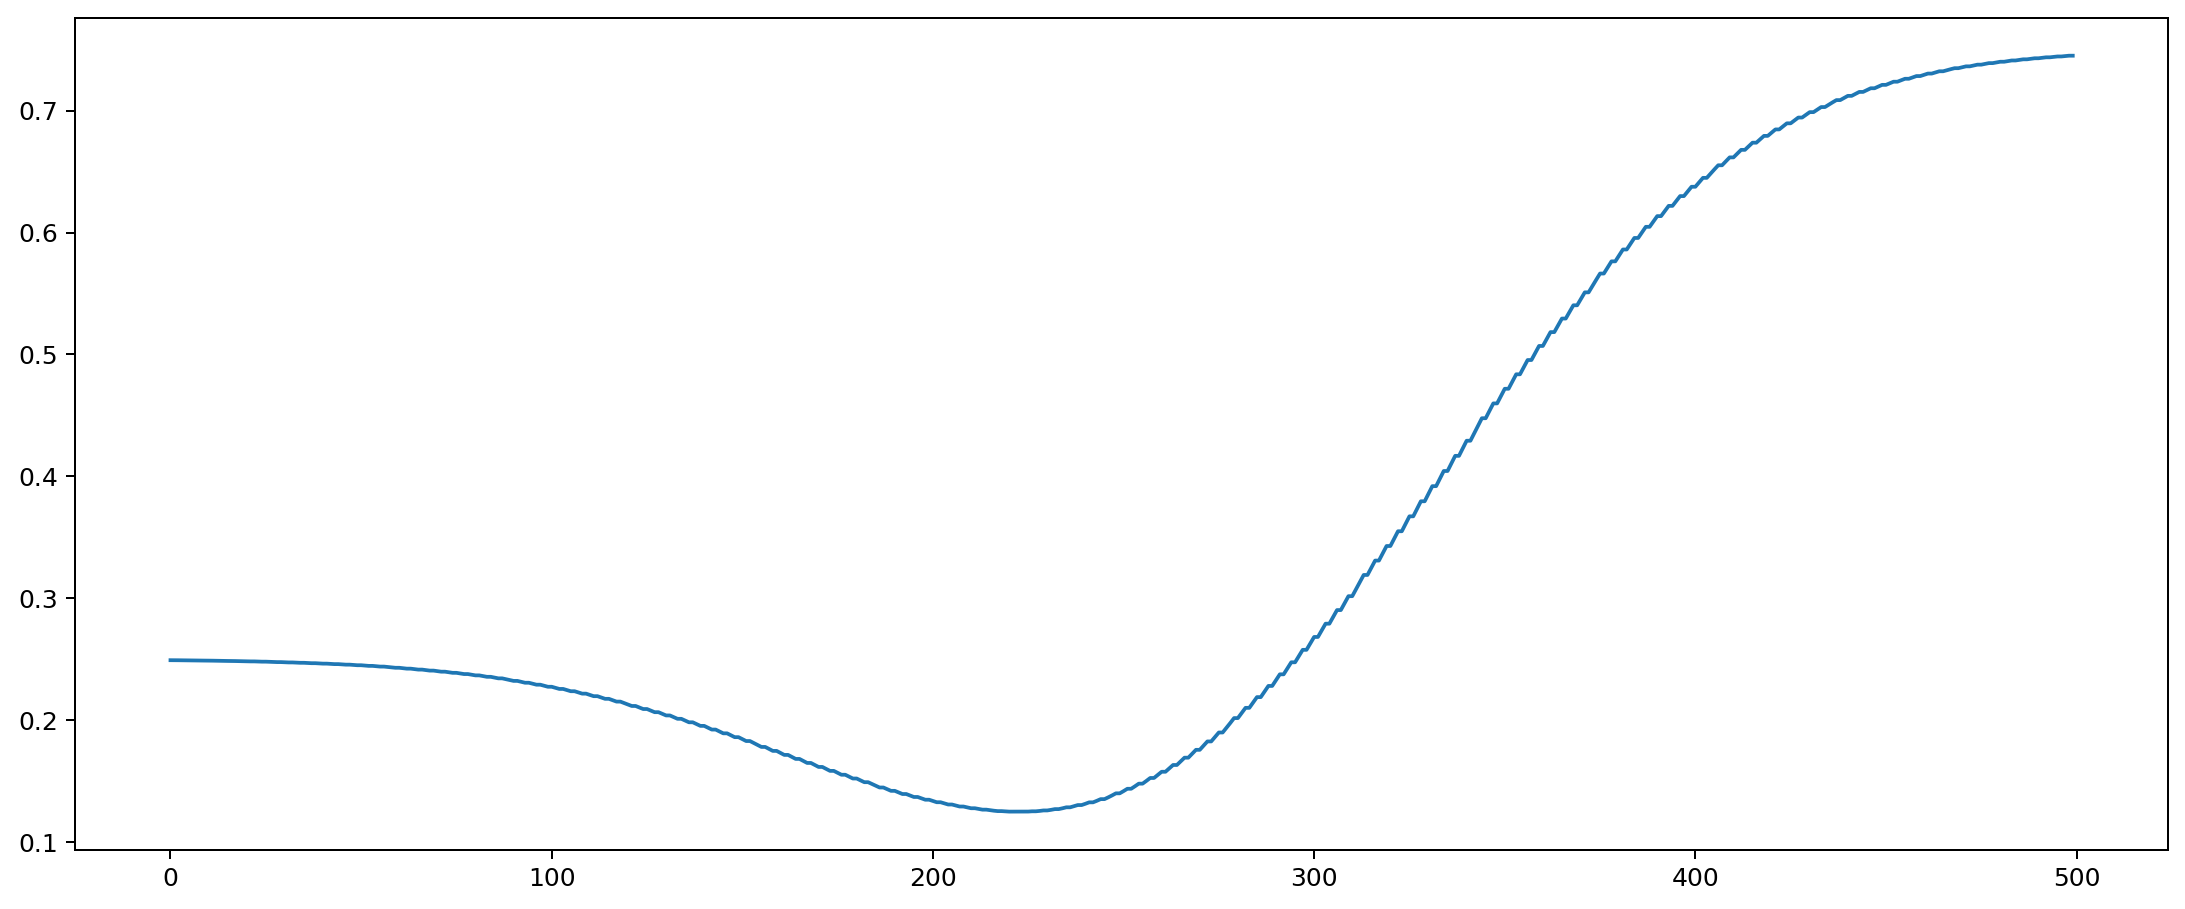

In [16]:
print(len(error))
plt.plot(error)
plt.show()


umbral ideal: -0.2556
Error: 0.12507025068837363


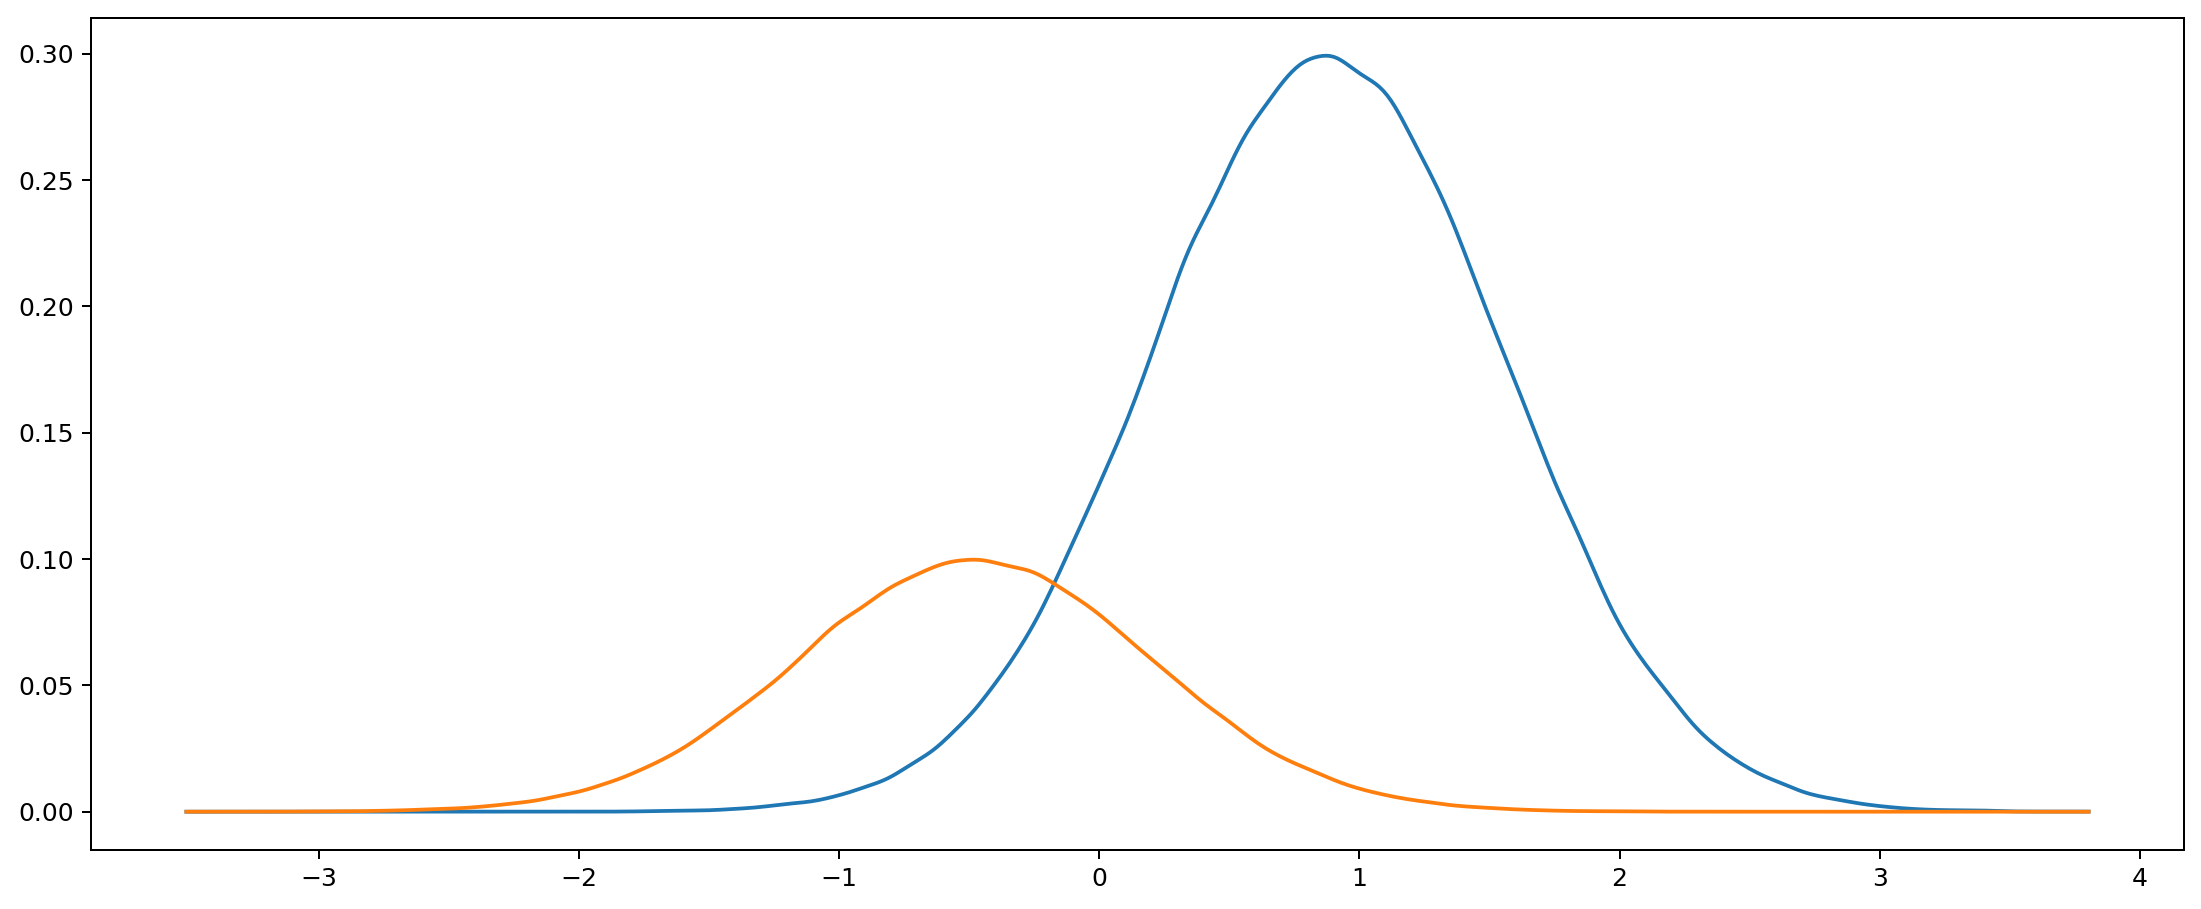

In [17]:
# Calcula la pdf de la señal corrupta para cada valor de símbolo
std = np.sqrt(σ2)
y1 = S1_pdf[1]
y1 = y1 * p_1
y0 = S0_pdf[1]
y0 = y0 * p_0
y = umbral[0]

ideal_umbral = umbral[0][np.argmin(error)]
min_error = error[np.argmin(error)]
print(f'umbral ideal: {round(ideal_umbral,4)}\nError: {min_error}')

plt.plot(y,y1)
plt.plot(y,y0)
plt.show()



Threshold computation

In [18]:
@interact(u=(umbral[0][1], umbral[0][-1], 0.1))
def umbral_interact(u=ideal_umbral):
    """
    Función interactiva que permite al usuario ajustar un umbral y visualizar
    cómo afecta a la estimación de la pdf de la señal y al error resultante.

    Parámetros:
    - u: Valor de umbral seleccionado por el usuario.
    """
    plt.figure()  # Creación de una nueva figura
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    plt.grid(True)

    # Visualización de las regiones de decisión basadas en el umbral
    plt.fill_between(y[y>u], y1[y>u], color='#F0F', zorder=90)
    plt.fill_between(y[y>u], y0[y>u], color='#A0A', zorder=90)
    plt.fill_between(y[y<u], y0[y<u], color='#0FF', zorder=90)
    plt.fill_between(y[y<u], y1[y<u], color='#0AA', zorder=90)

    # Visualización de las estimaciones de pdf
    plt.plot(y, y1, linestyle='--', color='w', zorder=99)
    plt.plot(y, y0, linestyle='--', color='w', zorder=99)

    # Línea vertical indicando el umbral seleccionado
    plt.vlines(u, 0, 0.12, color='k', linestyle='--', zorder=100)

    ax2 = plt.subplot2grid((3, 1), (2, 0))
    plt.grid(True)

    # Visualización del error en función del umbral
    xerror = np.linspace(y[0], y[-1], len(error))
    error_ = np.array(error)
    error_value = error[(abs(y-u)).argmin()]
    plt.plot(xerror, error_, color='C3', label=f'Error: {error_value:0.2f}')
    plt.vlines(u, error_.min(), error_.max(), color='k', linestyle='--')
    plt.legend()
    plt.ylabel('Error')
    plt.xlabel('Umbral')
    plt.show()

interactive(children=(FloatSlider(value=-0.25556131259369597, description='u', max=3.8023895046530045, min=-3.…